# Import Library

In [1]:
import os
import glob

import torch

import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from skimage.transform import resize
from typing import Dict, Tuple, List

# Config

In [2]:
DATASET_DIR = '/kaggle/input/mosmeddata-ct-hemorrhage-type-viii/MosMedData-CT-HEMORRHAGE-type VIII/'  # Adjust this to your Kaggle dataset path
IMG_SIZE = (512, 512)
BATCH_SIZE = 16
MAX_IMAGES_PER_SERIES = 512
START_IDX = 0

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read Image

In [4]:
def find_clinical_sheet(excel_file, keywords):
    """
    Finds the sheet containing clinical data in an Excel file.

    Parameters:
    excel_file (pd.ExcelFile): The Excel file object.
    keywords (list): List of keywords to identify the clinical sheet.

    Returns:
    str: The name of the sheet containing clinical data.

    Raises:
    ValueError: If no sheet with clinical data is found.
    """
    for sheet in excel_file.sheet_names:
        if any(keyword in sheet.lower() for keyword in keywords):
            return sheet
    
    raise ValueError('No clinical sheet found in the Excel file.')

def read_clinical_data(file_path):
    """
    Reads clinical data from an Excel file.

    Parameters:
    file_path (str): The path to the Excel file.

    Returns:
    pandas.DataFrame: A DataFrame containing the clinical data.

    Raises:
    ValueError: If no sheet with clinical data is found in the Excel file.
    """
    clinical_keywords = ['clinical', 'клинические']
    
    try:
        xls = pd.ExcelFile(file_path)
        clinical_sheet = find_clinical_sheet(xls, clinical_keywords)
        return pd.read_excel(xls, clinical_sheet)
    except ValueError as e:
        raise ValueError(f"Error reading clinical data: {str(e)}")

In [5]:
def preprocess_images(dicom_images, img_size=IMG_SIZE):
    """
    Preprocesses DICOM images for machine learning model input.

    Parameters:
    dicom_images (dict): A dictionary with a single key, where the value is a list of pydicom.dataset.FileDataset objects.
    img_size (tuple): Target image size (height, width). Default is (512, 512).

    Returns:
    numpy.ndarray: 4D array of preprocessed images (n_images, height, width, 3).
    """
    # Get the list of DICOM images from the dictionary
    images_list = list(dicom_images.values())[0]
    
    # Apply preprocess_single_image to each image in the list
    return np.array([preprocess_single_image(img, img_size) for img in images_list])

def preprocess_single_image(dicom_image, img_size):
    """
    Preprocesses a single DICOM image.

    Parameters:
    dicom_image (pydicom.dataset.FileDataset): DICOM image object.
    img_size (tuple): Target image size (height, width).

    Returns:
    numpy.ndarray: Preprocessed image as a 3D array (height, width, 3).
    """
    image_array = dicom_image.pixel_array
    normalized_image = normalize_image(image_array)
    resized_image = resize_image(normalized_image, img_size)
    return convert_to_rgb(resized_image)

def normalize_image(image):
    """
    Normalizes image pixel values to [0, 1] range.

    Parameters:
    image (numpy.ndarray): Input image array.

    Returns:
    numpy.ndarray: Normalized image array.
    """
    max_value = np.max(image)
    return image / max_value if max_value > 0 else np.zeros_like(image)

def resize_image(image, target_size):
    """
    Resizes image to target size using anti-aliasing.

    Parameters:
    image (numpy.ndarray): Input image array.
    target_size (tuple): Target image size (height, width).

    Returns:
    numpy.ndarray: Resized image array.
    """
    return resize(image, target_size, anti_aliasing=True)

def convert_to_rgb(image):
    """
    Converts grayscale image to RGB if necessary.

    Parameters:
    image (numpy.ndarray): Input image array.

    Returns:
    numpy.ndarray: RGB image array.
    """
    if len(image.shape) == 2:
        return np.stack((image,) * 3, axis=-1)
    return image

In [6]:
class BaseDatasetGenerator(Dataset):
    def __init__(self, dataset_dir: str, start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        self.dataset_dir = dataset_dir
        self.start_idx = start_idx
        self.batch_size = batch_size
        self.max_images_per_series = max_images_per_series
        self.studies_folders = self._get_studies_folders()
        self.clinical_data = self._load_clinical_data()
        self.study_uids = self._get_study_uids()
        self.current_index = self.start_idx

    def _get_studies_folders(self) -> List[str]:
        """Get all studies folders in the dataset directory."""
        return [f for f in os.listdir(self.dataset_dir) if os.path.isdir(os.path.join(self.dataset_dir, f))]

    def _load_clinical_data(self) -> pd.DataFrame:
        """Load clinical data from Excel files in all studies folders."""
        all_clinical_data = []
        for folder in self.studies_folders:
            folder_path = os.path.join(self.dataset_dir, folder, folder)
            excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
            
            if not excel_files:
                print(f"Warning: No Excel file found in {folder_path}")
                continue
            
            if len(excel_files) > 1:
                print(f"Warning: Multiple Excel files found in {folder_path}. Using the first one.")
            
            excel_path = excel_files[0]
            df = pd.read_excel(excel_path)
            df['folder'] = folder  # Add a column to identify the source folder
            all_clinical_data.append(df)
        
        if not all_clinical_data:
            raise FileNotFoundError(f"No Excel files found in any of the studies folders in {self.dataset_dir}")
        
        return pd.concat(all_clinical_data, ignore_index=True)

    def _get_study_uids(self) -> np.ndarray:
        """Extract unique study UIDs from the clinical data."""
        return self.clinical_data['study_uid'].unique()

    def __len__(self) -> int:
        """Return the total number of studies in the dataset."""
        return len(self.study_uids)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Dict]:
        """
        Get the preprocessed images and labels for a specific study.

        Args:
            idx (int): Index of the study to retrieve.

        Returns:
            Tuple[np.ndarray, Dict]: Preprocessed images and labels for the study.
        """
        study_uid = self.study_uids[idx]
        dicom_series = self._load_dicom_images(study_uid)
        labels = self._get_labels(study_uid)
        processed_images = self.preprocess_images(dicom_series, img_size=(512, 512))
        return processed_images, labels

    def _load_dicom_images(self, study_uid: str) -> Dict[str, List[pydicom.dataset.FileDataset]]:
        """
        Load DICOM images for a specific study from the appropriate folder.

        Args:
            study_uid (str): Unique identifier for the study.

        Returns:
            Dict[str, List[pydicom.dataset.FileDataset]]: Dictionary of DICOM images by series UID.
        """
        dicom_series = {}
        study_folder = self.clinical_data[self.clinical_data['study_uid'] == study_uid]['folder'].iloc[0]
        study_path = os.path.join(self.dataset_dir, study_folder, study_folder, study_uid)
        
        for root, _, files in os.walk(study_path):
            for file in files:
                if file.endswith('.dcm'):
                    file_path = os.path.join(root, file)
                    dicom_image = pydicom.dcmread(file_path, force=True)
                    series_uid = dicom_image.SeriesInstanceUID
                    if series_uid not in dicom_series:
                        dicom_series[series_uid] = []
                    dicom_series[series_uid].append(dicom_image)
        return dicom_series

    def _get_labels(self, study_uid: str) -> Dict:
        """
        Get labels for a specific study.

        Args:
            study_uid (str): Unique identifier for the study.

        Returns:
            Dict: Labels for the study, or None if not found.
        """
        study_clinical_data = self.clinical_data[self.clinical_data['study_uid'] == study_uid]
        return study_clinical_data.iloc[0].to_dict() if not study_clinical_data.empty else None

    @staticmethod
    def preprocess_images(dicom_series: Dict[str, List[pydicom.dataset.FileDataset]], img_size: Tuple[int, int]) -> np.ndarray:
        """
        Preprocess DICOM images.

        Args:
            dicom_series (Dict[str, List[pydicom.dataset.FileDataset]]): Dictionary of DICOM images by series UID.
            img_size (Tuple[int, int]): Target image size.

        Returns:
            np.ndarray: Preprocessed images.
        """
        # Implement your image preprocessing logic here
        # This is a placeholder implementation
        processed_images = []
        for series in dicom_series.values():
            for dicom_image in series:
                # Extract pixel array and resize
                pixel_array = dicom_image.pixel_array
                resized_image = np.resize(pixel_array, img_size)
                processed_images.append(resized_image)
        return np.array(processed_images)

class TrainDatasetGenerator(BaseDatasetGenerator):
    def __init__(self, dataset_dir: str, studies_folder: str, 
                 start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        super().__init__(dataset_dir, start_idx, batch_size, max_images_per_series)
        self.studies_folder = studies_folder
        # Additional initialization using studies_folder if needed

class TestDatasetGenerator(BaseDatasetGenerator):
    """
    Dataset generator for test data.

    This class inherits from BaseDatasetGenerator and can be extended with
    test-specific functionality as needed.
    """

    def __init__(self, dataset_dir: str, 
                 start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        super().__init__(dataset_dir, start_idx, batch_size, max_images_per_series)
        # Additional initialization for test dataset if needed


In [7]:
# Example usage
studies_folder = '400_500_studies'

train_dataset = TrainDatasetGenerator(dataset_dir=DATASET_DIR, studies_folder=studies_folder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
def plot_dicom_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f"Image {i+1}")
            # ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Labels:")
    for key, value in labels.items():
        print(f"{key}: {value}")


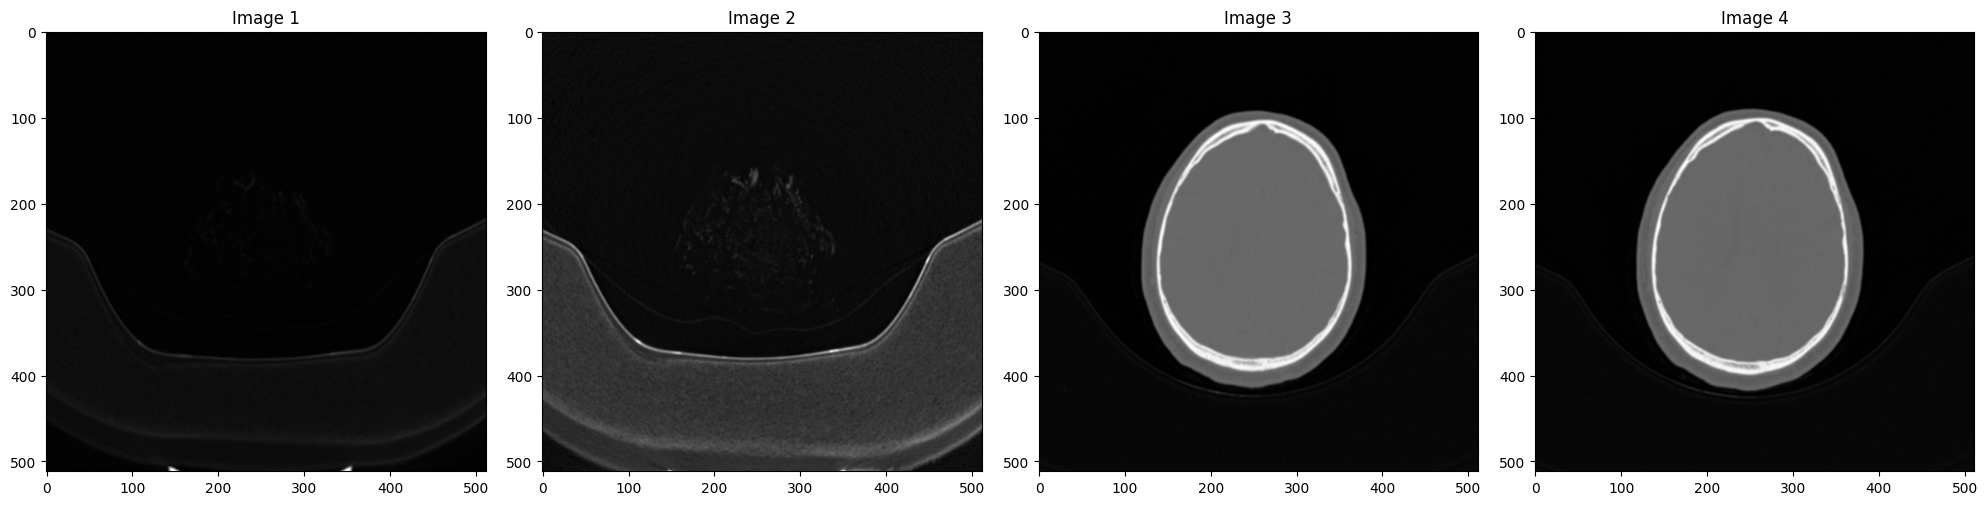

Labels:
study_uid: 1.2.643.5.1.13.13.12.2.77.8252.00020115041108011302101205050001
Radiology text report (in russian): При КТ головного мозга на нативных томограммах в проекции глубоких структур правого полушария отмечается кровоизлияние объемом до 12 см3 . Цистерны мозга хорошо прослеживаются во всех отделах . Четвертый , третий и боковые желудочки не расширены . Правый боковой желудочек несколько поддавлен . Смещения срединных структур не выявлено . Межгирусные пространства на уровне кровоизлияния несколько сглажены . Отмечается неравномерное утолщение слизистой околоносовых пазух . В костях свода и основания черепа изменения не выявлены . КТ картина внутримозгового кровоизлияния в правом полушарии головного мозга .
ICH: hemorrhage
epidural hemorrhage: 0
subarachnoid hemorrhage: 0.0
subdural hemorrhage: 0.0
intracerebral hemorrhage: 1.0
multiple hemorrhages: 0
skull fracture: 0.0
combined pathologies: nan
break in the cerebrospinal fluid spaces: nan
Comment: nan
folder: 500_600_studi

In [9]:
first_images, first_labels = train_dataset.__getitem__(0)

plot_dicom_images(first_images, first_labels)